<a href="https://colab.research.google.com/github/Tanya-Sood/Facial-expression-recognition/blob/main/Facial_Expression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

In [1]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-wpwvr_dq
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-wpwvr_dq
  Resolved https://github.com/albumentations-team/albumentations to commit 649fa0d8f3bbbaa4406359fdc244cedbae58f7d8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
# configurations
train_img_folder='/content/Facial-Expression-Dataset/train'
valid_img_folder='/content/Facial-Expression-Dataset/validation'
lr=0.001
epochs=15
batch_size=32
device='cuda'
model='efficientnet_b0'

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [5]:
#dynamic augmentations
train_augs=T.Compose([
    T.RandomHorizontalFlip(p=0.5), #flip images randomly for generalization
    T.RandomRotation(degrees=(-20,+20)), #roatate a little
    T.ToTensor() #converts PIL or numpy array to tensor torch, i.e. (h,w,c)->(c,h,w)
])
valid_augs=T.Compose([
    T.ToTensor()
])

In [6]:
#loading of dataset
trainset=ImageFolder(train_img_folder, transform=train_augs)
validset=ImageFolder(valid_img_folder, transform=valid_augs)

In [7]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [8]:
#labels
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

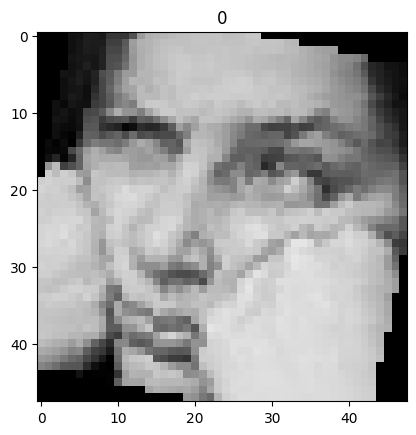

In [9]:
#example
image,label=trainset[10]
plt.imshow(image.permute(1,2,0))
plt.title(label)

In [10]:
from torch.utils.data import DataLoader

In [11]:
#load data to batches
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader=DataLoader(validset,batch_size=batch_size)

In [12]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [13]:
#to lead the first batch
for images,labels in trainloader:
  break

print(f"One image batch shape : {images.shape}") # no. of images, no. of channels, height, width
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


In [14]:
import timm
from torch import nn

In [15]:
class FaceModel(nn.Module):

  def __init__(self):
     super(FaceModel,self).__init__()
     self.eff_net=timm.create_model(model,pretrained=True,num_classes=7)

  def forward(self,images,labels=None):
    logits=self.eff_net(images)

    if labels is not None:
      loss=nn.CrossEntropyLoss()(logits,labels)
      return logits,loss

    return logits

In [16]:
Model=FaceModel()
Model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv

In [17]:
from tqdm import tqdm

In [18]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [19]:
def train_fn(model,dataloader,optimizer,current_epo):
  model.train()
  total_loss=0.0
  total_acc=0.0
  tk=tqdm(dataloader,desc="epoch" + "[TRAIN]" + str(current_epo+1) + "/" + str(epochs))

  for t,data in enumerate(tk):
    images,labels=data
    images,labels=images.to(device),labels.to(device)

    optimizer.zero_grad()
    logits,loss=model(images,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    total_acc+=multiclass_accuracy(logits,labels)
    tk.set_postfix({'loss': '%6f' %float(total_loss/(t+1)), 'acc': '%6f' %float(total_acc/(t+1)),})

  return total_loss/len(dataloader), total_acc/len(dataloader)

In [20]:
def eval_fn(model,dataloader,current_epo):
  model.eval()
  total_loss=0.0
  total_acc=0.0
  tk=tqdm(dataloader,desc="epoch" + "[VALID]" + str(current_epo+1) + "/" + str(epochs))

  for t,data in enumerate(tk):
    images,labels=data
    images,labels=images.to(device),labels.to(device)

    logits,loss=model(images,labels)

    total_loss+=loss.item()
    total_acc+=multiclass_accuracy(logits,labels)
    tk.set_postfix({'loss': '%6f' %float(total_loss/(t+1)), 'acc': '%6f' %float(total_acc/(t+1)),})

  return total_loss/len(dataloader), total_acc/len(dataloader)

In [21]:
# create training loop
optimizer=torch.optim.Adam(Model.parameters(),lr=lr)

In [22]:
best_valid_loss=np.inf

for epoch in range(epochs):
  train_loss,train_acc=train_fn(Model,trainloader,optimizer,epoch)
  valid_loss,valid_acc=eval_fn(Model,trainloader,epoch)

  if valid_loss<best_valid_loss:
    torch.save(Model.state_dict(),'best-weights.pt')
    print("Saved best weights")
    best_valid_loss=valid_loss

epoch[VALID]1/15: 100%|██████████| 901/901 [00:31<00:00, 28.99it/s, loss=1.340057, acc=0.483188]


Saved best weights


epoch[VALID]2/15: 100%|██████████| 901/901 [00:29<00:00, 30.17it/s, loss=1.185654, acc=0.548810]


Saved best weights


epoch[VALID]3/15: 100%|██████████| 901/901 [00:29<00:00, 30.10it/s, loss=1.093204, acc=0.589578]


Saved best weights


epoch[VALID]4/15: 100%|██████████| 901/901 [00:29<00:00, 30.53it/s, loss=1.035372, acc=0.614418]


Saved best weights


epoch[VALID]5/15: 100%|██████████| 901/901 [00:29<00:00, 30.70it/s, loss=1.019426, acc=0.616616]


Saved best weights


epoch[VALID]6/15: 100%|██████████| 901/901 [00:29<00:00, 30.10it/s, loss=0.999209, acc=0.627735]


Saved best weights


epoch[VALID]7/15: 100%|██████████| 901/901 [00:29<00:00, 30.73it/s, loss=0.950915, acc=0.645420]


Saved best weights


epoch[VALID]8/15: 100%|██████████| 901/901 [00:31<00:00, 28.86it/s, loss=0.933541, acc=0.652344]


Saved best weights


epoch[VALID]9/15: 100%|██████████| 901/901 [00:29<00:00, 30.16it/s, loss=0.904717, acc=0.666391]


Saved best weights


epoch[VALID]11/15: 100%|██████████| 901/901 [00:29<00:00, 30.92it/s, loss=0.877125, acc=0.665263]


Saved best weights


epoch[VALID]12/15: 100%|██████████| 901/901 [00:29<00:00, 30.64it/s, loss=0.868999, acc=0.677384]


Saved best weights


epoch[VALID]13/15: 100%|██████████| 901/901 [00:29<00:00, 30.29it/s, loss=0.804571, acc=0.703378]


Saved best weights


epoch[VALID]14/15: 100%|██████████| 901/901 [00:29<00:00, 30.70it/s, loss=0.780384, acc=0.716856]


Saved best weights


epoch[VALID]15/15: 100%|██████████| 901/901 [00:28<00:00, 31.09it/s, loss=0.704214, acc=0.747620]


Saved best weights


In [23]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [24]:
# Load the best model weights
Model.load_state_dict(torch.load('best-weights.pt'))
Model.eval()

# Function to predict on a single image
def predict_image(image, model):
    image = image.unsqueeze(0)  # Add batch dimension: [C,H,W] -> [1,C,H,W]
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        probs = torch.softmax(output, dim=1)
    return probs

True Label: happy, Predicted Label: happy
True Label: happy, Predicted Label: happy
True Label: surprise, Predicted Label: surprise
True Label: happy, Predicted Label: happy
True Label: fear, Predicted Label: happy


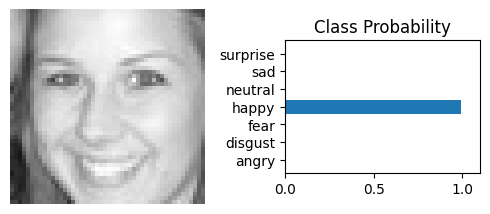

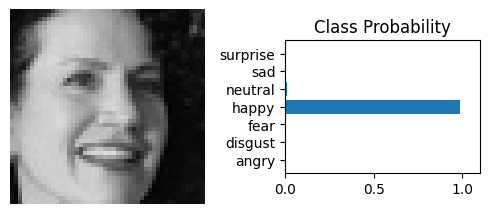

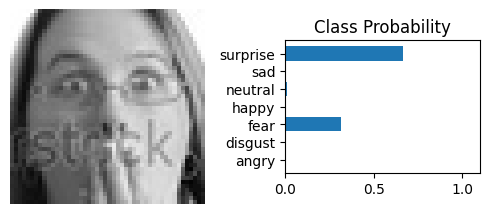

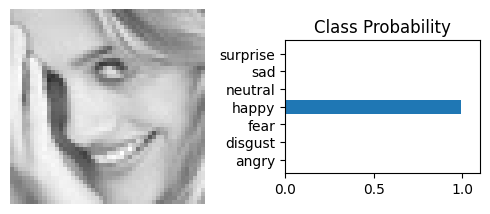

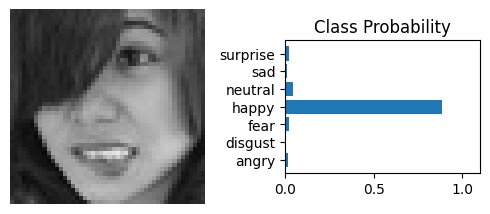

In [25]:
# View sample predictions from validation set
import random

def visualize_predictions(model, dataset, n_images=5):
    model.eval()
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    for i in range(n_images):
        idx = random.randint(0, len(dataset) - 1)
        image, true_label = dataset[idx]

        probs = predict_image(image, model)
        pred_label = torch.argmax(probs, dim=1).item()

        print(f"True Label: {classes[true_label]}, Predicted Label: {classes[pred_label]}")
        view_classify(image.cpu(), probs.cpu())

# Now call the function to see 5 random predictions
visualize_predictions(Model, validset, n_images=5)

In [26]:
def evaluate_full_dataset(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

# Call this function after loading best weights
evaluate_full_dataset(Model, validloader)

Validation Accuracy: 64.83%


Validation Accuracy: 64.83%
True Label: neutral, Predicted Label: fear
True Label: fear, Predicted Label: fear
True Label: happy, Predicted Label: happy
True Label: fear, Predicted Label: neutral
True Label: fear, Predicted Label: fear


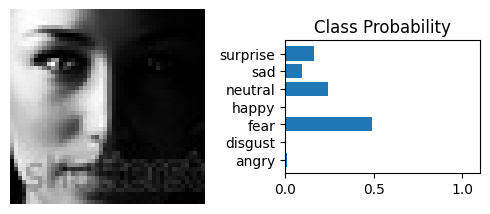

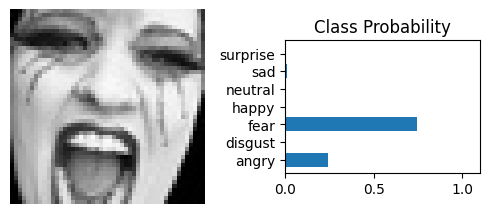

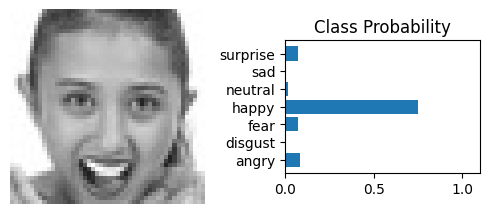

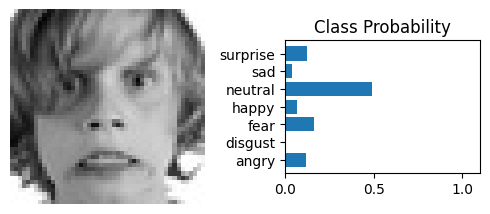

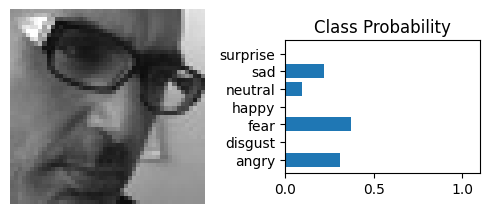

In [27]:
# Load best model
Model.load_state_dict(torch.load('best-weights.pt'))
Model.eval()

# Evaluate full validation accuracy
evaluate_full_dataset(Model, validloader)

# Visualize some random predictions
visualize_predictions(Model, validset, n_images=5)

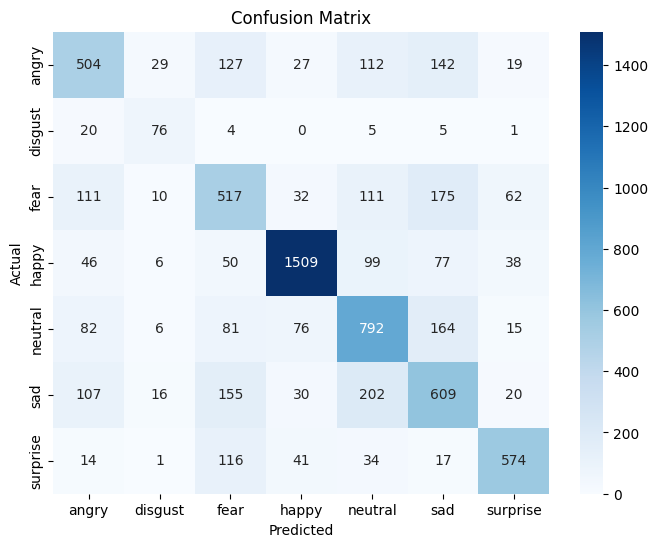

Classification Report:
              precision    recall  f1-score   support

       angry       0.57      0.53      0.55       960
     disgust       0.53      0.68      0.60       111
        fear       0.49      0.51      0.50      1018
       happy       0.88      0.83      0.85      1825
     neutral       0.58      0.65      0.62      1216
         sad       0.51      0.53      0.52      1139
    surprise       0.79      0.72      0.75       797

    accuracy                           0.65      7066
   macro avg       0.62      0.64      0.63      7066
weighted avg       0.66      0.65      0.65      7066



In [28]:
#final reports
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

def get_preds_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_preds, all_labels

# Get predictions and true labels
preds, labels = get_preds_and_labels(Model, validloader)

# Define class names
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Confusion Matrix
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(labels, preds, target_names=class_names))